In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import colors as colors
import matplotlib.patches as patches

import math
import json
import numpy as np

import ACClasses

# Basic Design Considerations : XLZD 
* TPC Radius~Height = 298cm  


* Electric Field : Between 240 and 290 V/cm  
* The extraction field 6-8kV/cm
* Base_Model : 60t  
* Charge-insensitive mass below the cathode : 10cm  
* LXe skin : 7 cm  
(extra 30 cm below the photocathodes of the bottom
photosensor array)   
* 3 inch PMT Array : 1182 PMTS Top array and same for bottom.  
* PMTs average quantum effciency : 34% at 20C (at a
average internal photo electron collection effciency of 90%.)
* Electron life_time : 10ms or better 




# Params Used in FD And Pranati's code :

* Drift field : 80 V/cm in FD v/s 200V/cm in Pranati's
> Why so less ?

* Extraction Field : 7.5 kV/cm

* g1 : 0.27 
> Acc to ROB it's PMT q.effciency  
> In Pranati's code, it's calculated via a formula :  PMTDetectionProb*(LCETop + LCEBottom)/2, where PMTDetProb is the avg PMT quantum efficiency as described in comments : ACCClasses.py)


* g2 : 44.65305146945426
> Is calculated via a fn in parameter_calc.py in fd  

* Extraction Efficiency : 0.93 at 160K and 7.5kV/cm Extraction Field
> Is calc via fn parameter_calc.py  
> It is higher ~0.94 for 8kV/cm
* electron_lifetime : 10ms 
> User input 

* Extraction Efficiency :  0.8993482035526084
> Calc via a fn in parameter_calc.py in fd  
> User input in Pranati's code 

# Function to print LY and CY

In [23]:
print(ACClasses.ReadNest("ER",10,"electrons",200))
print(ACClasses.ReadNest("ER",10,"photons",200))
print(ACClasses.ReadNest("NR",40,"electrons",200))
print(ACClasses.ReadNest("NR",40,"photons",200))
print("The electron drift speed is", f'{ACClasses.fElectronDriftSpeed(200)} mm/mus for 200V/cm')
print("The Active LXe volume is  ", f'{ACClasses.fToMass(300,300)} Tonnes')

283.842146583
451.203953808
152.386450152
483.88157333
The electron drift speed is 1.2393499555011886 mm/mus for 200V/cm
The Active LXe volume is   243.35719172502618 Tonnes


# Scaling for XLZD

In [4]:
# We calc the surface area of the detector here, to be used later when specifying detector config.

Area_XLZD60t_lid = 298.*298.*np.pi  # in cm^2
Area_XLZD60t= 2*Area_XLZD60t_lid+np.pi*2.*298. * 298. #in cm^2

# Since the OG code for whatever reasons uses XENON1T as a variable name in many places like Particle background, it's easier to switch our XLZD variable to XENON, for convenience sake : 
Area_Xenon1t_lid=Area_XLZD60t_lid 
Area_Xenon1t=Area_XLZD60t

# Not sure what this is ? 
Area_LZPTFE = np.pi*2.*75. * 150. #cm^2 

Set up our detector

In [5]:
# Everything taken from design book : paste url, values in cm for height, radius etc..
XLZDdetector = ACClasses.Detector(TPCHeight=298., 
               TPCRadius = 298.,
               BelowCathodeHeight = 10.,
               FiducialCut = 7.,
               ExtractionEfficiency = 0.90, # not mentioned in DB, using FD value, FD it depends upon temperature, either decrease temp or increase extraction field 
               g2 =  44.65305146945426,# g2 factor not mentioned for XLZD, using FD value,
               SEGain = 40, #important factor down the line, need to fix carefully
               LCETop = 0.49, # not mentioned maybe Owen can help
               LCEBottom = 0.49, # Not mentioned
               PMTDetectionProb = 0.34, # As mentioned in DB
               PMTDarkRate = 13, # it's 12-14 as mentioned in design book
               DriftField = 200,
               ElectronLifetime = 10, # not mentioned explictly, XLZD wants better than 10ms
               PMTDensity = 1182./Area_Xenon1t_lid
                    )

detector= XLZDdetector
print(detector)

# Why is Rob using g1= 0.27 in FD for xlzd (he mentions it's "this represents PMT QE", even then it should be 0.34)?? 
# since LCE avg value per config is already mentioned XLZD.py, 0.49X0.34=0.16 it should be, for ref, LZ's g1 is 0.11


the fiducial mass is 227.45 tonnes
		the active mass is 238.52 tonnes
		the below-cathode mass is 8.00 tonnes
		the drift speed is 123.93cm/ms
		the max drift time is 2.40ms
		the number of PMTs is 1182 
		g1 is 0.17


In [6]:
def fElectronDriftSpeed(DriftField):
	a = 0.2459
	b =	 -0.30527
	return a/np.power(DriftField,b)

Electron_Drift_speed=fElectronDriftSpeed(80)/1e4 # dividing by 1e4 to convert mm/us to cm/ns

print("Electron Drift speed Pranati :", f'{Electron_Drift_speed} cm/ns')
print("Electron Drift_speed Rob : 15.032655984517694e-05 cm/ns")

Electron Drift speed Pranati : 9.369465341977855e-05 cm/ns
Electron Drift_speed Rob : 15.032655984517694e-05 cm/ns


# Drift_time 

> to be calc from drift speed as distance/speed  
> Important quantity : Used in Prob of all electrons lost calc : $1-e^{-(t_{drift}/\tau_{elife})}$

In [7]:
TPCHeight=300 #cm

MaxDriftTime = TPCHeight/Electron_Drift_speed     # ns 
print("The Max Drift Time is", f"{MaxDriftTime} ns or {MaxDriftTime*1e-6} ms")

The Max Drift Time is 3201890.27922346 ns or 3.2018902792234596 ms


# Backgrounds
As a first pass we are using the rates from XENON1t, will look into these numbers from FD workflow, however , they have been scaled appropriately for XLZD sized detector (again, the variable name suggests XENON1t, but that is only for convenience, the physical dimensions have been redefined for this variable in the very first block. )

# Particle Backgrounds 
* NR:
> CEvNS - modelled as a double exponential spectrum  
> Neutrons - modelled as a single exponential spectrum

* ER:
> Total ER rate in the relevant energy window where ~ < 200 photons are produced is approximately flat,so we model it as flat.  
> Individual contributions are not considered separately, only the sum spectrum.  



In [8]:
particleBackgroundsXENON1t = ACClasses.ParticleBackground(
        detector = detector,
        A1_cevns = 915, # NR background's CEvNS two exponentials. These come from a rough fit to the LZ background spectra
        b1_cevns = 0.5, # keV
        A2_cevns = 0.083, # events per (kev tonne year)
        b2_cevns = 16.7, # keV
        A_neutrons_fiducial = 0.005/Area_Xenon1t, # times 1 tonne to remove mass dependence Fig 8 in https://arxiv.org/pdf/1512.07501.pdf
        #A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        A_neutrons_edge = 125 * 2.0/Area_Xenon1t, # times 2 tonnes to remove mass dependence
        b_neutrons = 25., # keV
        FlatERRate_internal = 10.0,  # events per (kev, tonne, year) prediction for nT,  # Rn, Kr - events per (kev tonne year)
        FlatErRate_external = 100./Area_Xenon1t,   #events per (kev * yr* cm^2) (not per mass), only close to the walls in 1-12 keV from 1T; from https://arxiv.org/pdf/1512.07501.pdf
                        )
particleBackgrounds = particleBackgroundsXENON1t
particleBackgrounds.FlatERRate_internal = particleBackgrounds.FlatERRate_internal/100.
particleBackgrounds.FlatErRate_external = particleBackgrounds.FlatErRate_external/100.

# Instrumental Backgrounds 

> Again the rates for lone S1 and S2 are derived from Xenon1T , but scaled for XLZD, how would we get these rates for xlzd ? Also, what are these variables exactly ? Need to look up some theory on ACs !

In [9]:
instrumentalBackgrounds1T = ACClasses.InstrumentalBackground(
        detector = detector,
        A_unexplainedLoneS2 = 20.*6e9/Area_Xenon1t/ACClasses.SecondsPerYear,  # /(yr cm^2); to match lone S2 rate reoprted in XENON1T above 8 PE
        b1_unexplainedLoneS2 = 0.3,  # to match lone S2 spectrum observed in XENON1T
        b2_unexplainedLoneS2 = 1.8,  # to match lone S2 spectrum observed in XENON1T
        r_unexplainedLoneS2 = 0.9999,  # to match lone S2 spectrum observed in XENON1T
        c_unexplainedLoneS2 = 20.*450/Area_Xenon1t/ACClasses.SecondsPerYear,  # to match lone S2 spectrum observed in XENON1T
        unexplainedLoneS1Rate = 30000./Area_LZPTFE, # # to match the lone S1 rate observed in XENON1T
        S1MisclassificationProb = 0.00003, # Probability to misclassify a signal from SE as an S1. This is a wild guess
        )
#settings
instrumentalBackgrounds = instrumentalBackgrounds1T


# Range for plotting in cS1, cS2 space 



In [10]:
# For migdal, cs1 projections peaked at 5 and cS2 at 10^(3.5)
energyRange = 10 # keV
maxS1Range = 150
maxS2Range = 200

# Plots 

* Electron Loss Probability : the probability that all electrons from an interaction are absorbed , well defined function for the same.

* Photon Loss probability : the probability that all photons from an interaction are absorbed  


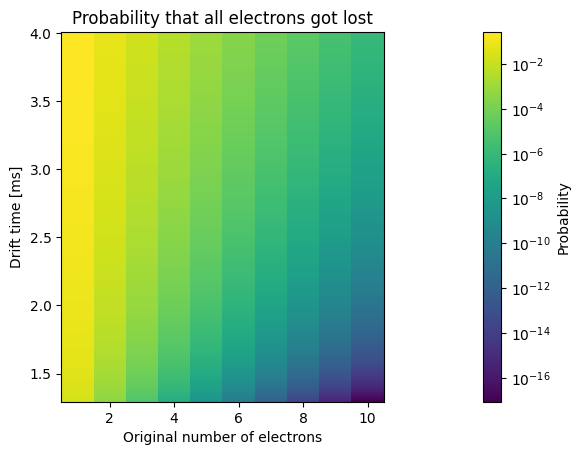

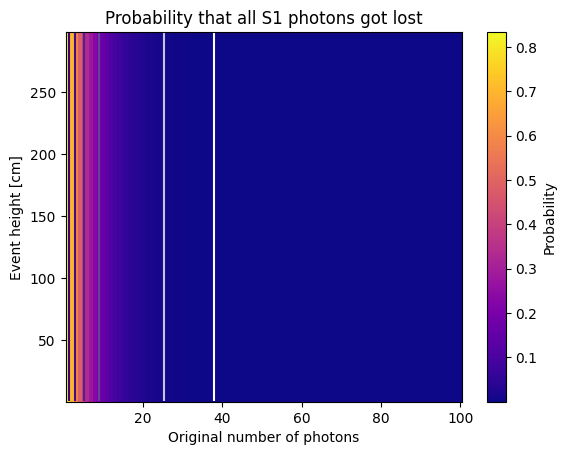

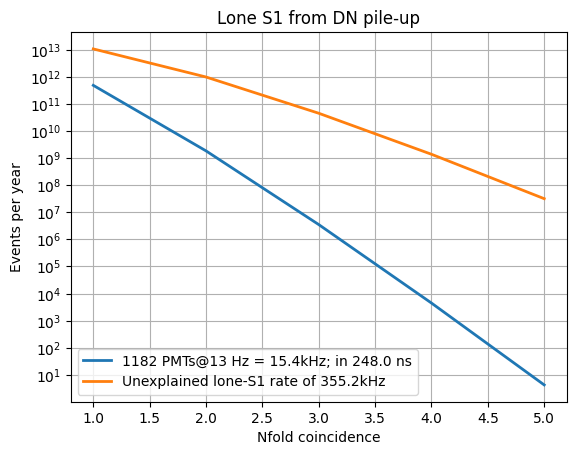

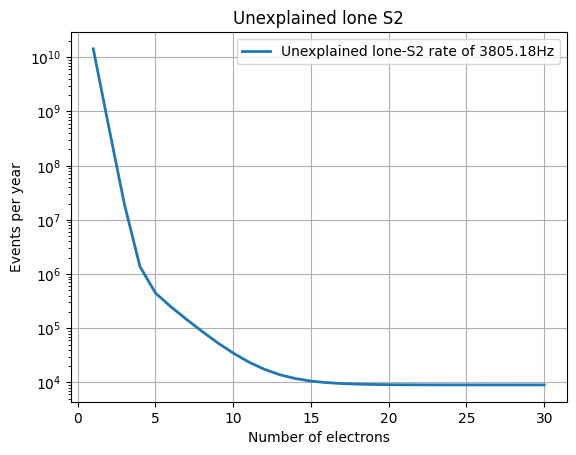

In [11]:
# Loss Probability
instrumentalBackgrounds.PlotElectronLossProbability()
instrumentalBackgrounds.PhotonLossProbability()
instrumentalBackgrounds.PlotDarkNoiseRate()


# BG Event Rates - XLZD

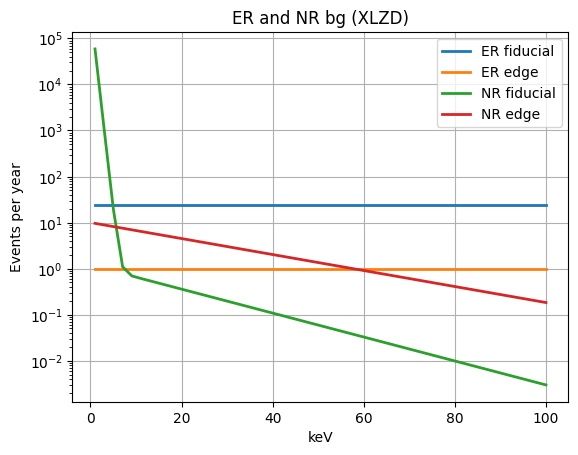

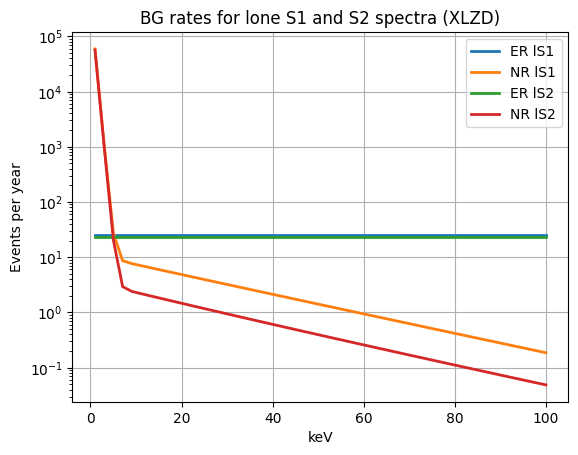

In [12]:
#Particle backgrounds

## In energy space

###This part is just to check that the energy spectra match whatever is expected from simulations
fig_bg, ax_bg = plt.subplots()
x_bg = np.linspace(1, 100, 50) #keV
y_bger_in = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "internal", detector.activeMass, -1)
y_bger_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "ER", "external", -1, detector.TPCArea)

y_bgnr_in = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "internal", detector.activeMass, -1)
y_bgnr_ex = particleBackgrounds.BackgroundSpectrum(x_bg, "NR", "external", -1, detector.TPCArea)

ax_bg.semilogy(x_bg, y_bger_in, linewidth=2.0, label="ER fiducial")
ax_bg.semilogy(x_bg, y_bger_ex, linewidth=2.0, label="ER edge")
ax_bg.semilogy(x_bg, y_bgnr_in, linewidth=2.0, label="NR fiducial")
ax_bg.semilogy(x_bg, y_bgnr_ex, linewidth=2.0, label="NR edge")

ax_bg.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg.grid()
ax_bg.legend()
ax_bg.set_xlabel("keV")
ax_bg.set_ylabel("Events per year")
ax_bg.set_title("ER and NR bg (XLZD)")
plt.show()

## Now we collect those sources and detector locations that can create LS1 or LS2 signals
### Backgrounds relevant to lone-s1
y_bger_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "ER")
y_bgnr_ls1 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S1", "NR")

### Backgrounds relevant to lone-s2
y_bger_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "ER")
y_bgnr_ls2 = particleBackgrounds.BackgroundSpectraForLone(x_bg, "S2", "NR")

fig_bg2, ax_bg2 = plt.subplots()
ax_bg2.semilogy(x_bg, y_bger_ls1, linewidth=2.0, label="ER lS1")
ax_bg2.semilogy(x_bg, y_bgnr_ls1, linewidth=2.0, label="NR lS1")
ax_bg2.semilogy(x_bg, y_bger_ls2, linewidth=2.0, label="ER lS2")
ax_bg2.semilogy(x_bg, y_bgnr_ls2, linewidth=2.0, label="NR lS2")

ax_bg2.yaxis.set_major_locator(ticker.LogLocator(base=10, numticks=25))
ax_bg2.grid()
ax_bg2.legend()
ax_bg2.set_xlabel("keV")
ax_bg2.set_ylabel("Events per year")
ax_bg2.set_title("BG rates for lone S1 and S2 spectra (XLZD)")
plt.show()


Not Sure what/how this works ..

It may take a moment for the blurring to finish.
It may take a moment for the blurring to finish.


/var/folders/11/qrrzf16128s2xj54lz_vslsm0000gn/T/ipykernel_14424/153304746.py:77: UserWarning: Adding colorbar to a different Figure <Figure size 640x480 with 2 Axes> than <Figure size 640x480 with 2 Axes> which fig.colorbar is called on.
  fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")


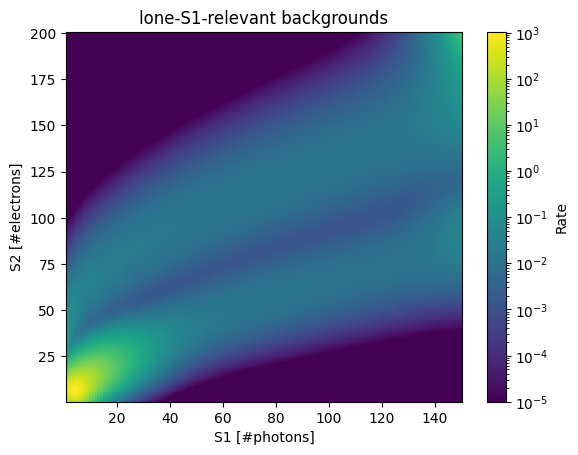

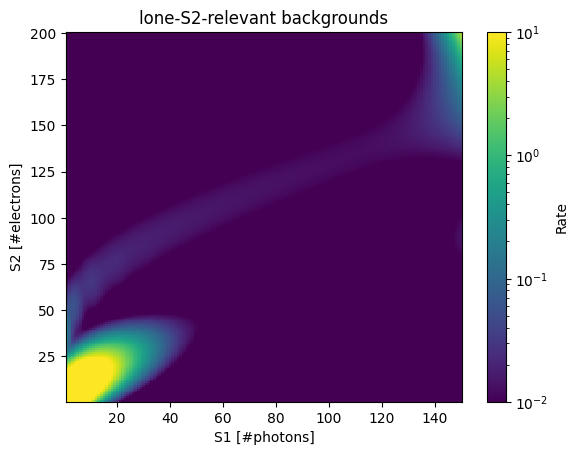

In [13]:
## Now convert those spectra to number-of-quanta space

S1q = []
S2q = []
Rq = []

    
binwidth = 0.25 # keV
''' We want finer binning than 1 keV, otherwise the spectra in 
    S1/S2 are not continuous. 
    '''
x_bg_l = np.linspace(0, energyRange, int(energyRange/binwidth))

#For the lone S1 signals:
def FillMatrix(a, b, c):
    S1q.append(a)
    S2q.append(b)
    Rq.append(c)

    
''' Get the central values for the number of S1 and S2 quanta produced. '''
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S1", "ER")
    FillMatrix(a, b, c)
    ''' Due to the quenching, the ER and NR energy to quanta conversion
    is at different scales - at the same energy, NR produce less quanta
    and we have to include higher energies.'''
    a, b = detector.EnergyToQuanta(x*2.,"NR") 
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S1", "NR")
    FillMatrix(a, b, c)    
''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
S1_forLS1, S2_forLS1, R_forLS1 = ACClasses.GaussianFilterGPT(Rq, S1q, S2q, binwidth, maxS1Range, maxS2Range, 0.2)

''' Make a nice plot '''
X_S1, Y_S2 = np.meshgrid(S1_forLS1, S2_forLS1)  
fig_xx, ax_xx = plt.subplots()    
max_val = np.max(R_forLS1[R_forLS1>0])
im_xx = ax_xx.pcolormesh(S1_forLS1, S2_forLS1, R_forLS1, norm=colors.LogNorm(vmin=1e-5,vmax=max_val))
ax_xx.set_xlabel("S1 [#photons]")
ax_xx.set_ylabel("S2 [#electrons]")
ax_xx.set_title("lone-S1-relevant backgrounds")
fig_xx.colorbar(im_xx, ax=ax_xx, pad=0.05, label="Rate")


S1q_2 = []
S2q_2 = []
Rq_2 = []

def FillMatrix_2(a, b, c):
    S1q_2.append(a)
    S2q_2.append(b)
    Rq_2.append(c)
#For the lone S2 signals:
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    c = particleBackgrounds.BackgroundSpectraForLone(x, "S2", "ER")
    FillMatrix_2(a, b, c)
    a, b = detector.EnergyToQuanta(x*2.,"NR")
    c = particleBackgrounds.BackgroundSpectraForLone(x*2., "S2", "NR")
    FillMatrix_2(a, b, c) 

S1_forLS2, S2_forLS2, R_forLS2 = ACClasses.GaussianFilterGPT(Rq_2,S1q_2,S2q_2,binwidth, maxS1Range, maxS2Range, 0.2)



fig_xxx, ax_xxx = plt.subplots()   
ax_xxx.set_xlabel("S1 [#photons]")
ax_xxx.set_ylabel("S2 [#electrons]")
ax_xxx.set_title("lone-S2-relevant backgrounds")
im_xxx = ax_xxx.pcolormesh(S1_forLS2, S2_forLS2,  R_forLS2,norm=colors.LogNorm(vmin=0.01,vmax=10)) 
fig_xx.colorbar(im_xxx, ax=ax_xxx, pad=0.05, label="Rate")

21914.375139147258, 21198.846449172048


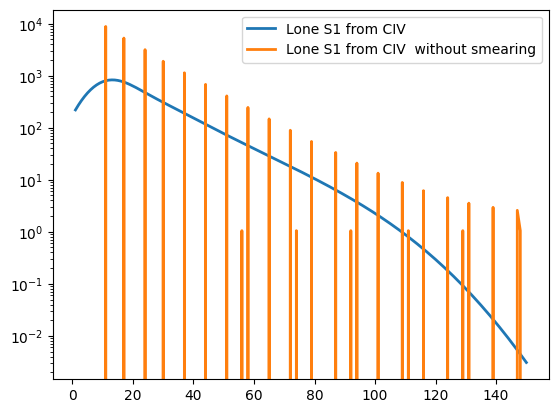

In [14]:
##Lone S1 from charge insensitive volume
binwidth = 0.25 # keV
''' We want finer binning than 1 keV, otherwise the spectra in 
    S1/S2 are not continuous. 
    '''
x_bg_l = np.linspace(0, energyRange, int(energyRange/binwidth))

S1only_FromCIV = np.linspace(1,maxS1Range,maxS1Range) #CIV = charge insensitive volume
Rq_CIV = []
for x in S1only_FromCIV:
    Rq_CIV.append(0.0)
    
def FillCIV(x, R):
    PE = 0
    for i in S1only_FromCIV:
        #print('i is',i)
        if (abs(i-x) < 1):
            PE = int(i) 
            break
    if (PE > 1):  #Otherwise, the number of PE created is out of range of the histogram
        Rq_CIV[PE] = Rq_CIV[PE] + R 
for x in x_bg_l:
    if x < binwidth:
        continue
    a, b = detector.EnergyToQuanta(x,"ER")
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"ER"))
    a, b = detector.EnergyToQuanta(x*2.,"NR")    
    FillCIV(a+b, particleBackgrounds.BackgroundSpectrumFromCIV(x,"NR"))

''' Now we apply a gaussian smearing to recreate the statistical fluctuations in the 
    number of quanta produced. This does not take the anti-correlation into account. '''    
R_LS1_ChargeIns = ACClasses.GaussianFilter1D(Rq_CIV, S1only_FromCIV, 1., maxS1Range, 1)

fig_bg3, ax_bg3 = plt.subplots()
ax_bg3.semilogy(S1only_FromCIV, R_LS1_ChargeIns, linewidth=2.0, label="Lone S1 from CIV") 
ax_bg3.semilogy(S1only_FromCIV, Rq_CIV, linewidth=2.0, label="Lone S1 from CIV  without smearing")
ax_bg3.legend()



Text(0.5, 1.0, 'Rate of lone S1 from rad. backgrounds in active volume and in CIV')

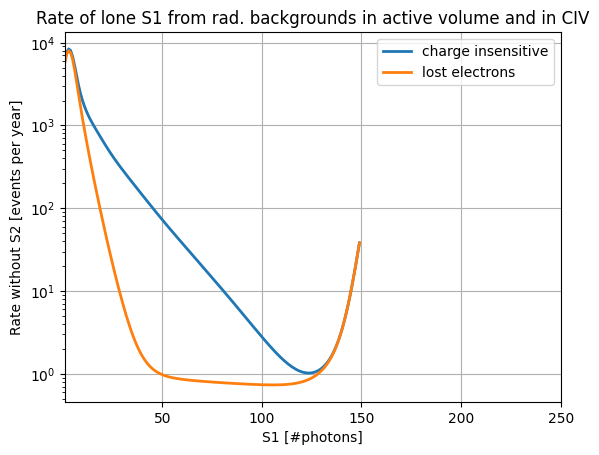

In [15]:
# Lone S1 from events where all e- are absorbed in active volume


R_LS1_Rad = []
R_LS1_RadChargeIns = [] # for the sum of the two components
x_LS1 = []
for i in range(len(R_forLS1)): # loop number of S1
    R_lost = 0.
    
    x_LS1.append(i)
    for j in range(len(R_forLS1[0])): #loop number of S2
        #Sample equally across length
        nsamples = 10
        for k in range(nsamples):
            R_lost = R_lost + R_forLS1[i,j]/nsamples*instrumentalBackgrounds.P_AllElectronsLost(j,k/nsamples * detector.MaxDriftTime)
    R_LS1_Rad.append(R_lost)
    R_LS1_RadChargeIns.append(R_lost+R_LS1_ChargeIns[i])
fig_noS2, ax_noS2 = plt.subplots()
ax_noS2.semilogy(x_LS1, R_LS1_RadChargeIns, linewidth=2.0, label="charge insensitive")
ax_noS2.semilogy(x_LS1, R_LS1_Rad, linewidth=2.0,  label="lost electrons")
ax_noS2.legend()
#ax_noS2.semilogy(x_LS1, R_LS1_ChargeIns, linewidth=2.0)
plt.xlim([1, 250])
ax_noS2.grid()
ax_noS2.set_xlabel("S1 [#photons]")
ax_noS2.set_ylabel("Rate without S2 [events per year]")
ax_noS2.set_title("Rate of lone S1 from rad. backgrounds in active volume and in CIV")     


In [16]:


x_DN = np.linspace(1, 8, 8)
y_DNCoincidenceRate = instrumentalBackgrounds.DNCoincidenceRate(x_DN)

x_LS1_PE = []
R_LS1_FromCIV_PE = [] 
R_LS1_Rad_PE = [] 


# Apply g1; axis is in PE after this
# In principle, we also have to think about coincidences between DC pile-up and real light,
# but as long as the rates are this low, the chance of that is negligible
for i in range(1,round(len(R_LS1_Rad)*detector.g1)):
    R_LS1_FromCIV_PE.append(R_LS1_ChargeIns[round(i/detector.g1)])
    R_LS1_Rad_PE.append(R_LS1_Rad[round(i/detector.g1)])
    x_LS1_PE.append(i)


Text(0.5, 1.0, 'Rate of S2 from rad. backgrounds in active volume without S1')

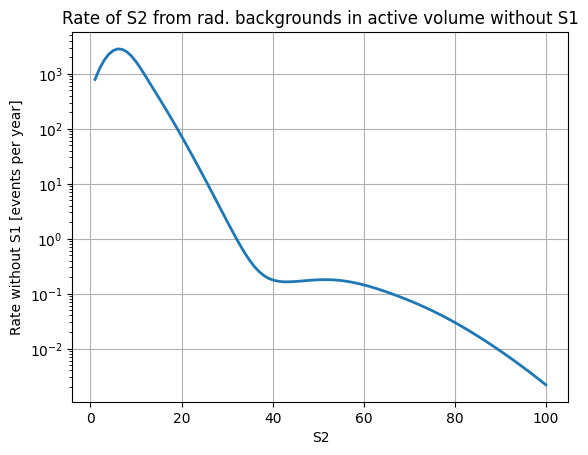

In [17]:
# Lone-S2  
#S1_2, S2_2, R_2, intrinsic only, since ext. events will be rejected from x-y position reconstruction based on S2 position
R_LS2 = []
x_LS2 = []
for j in range(1,len(R_forLS2[0])): # loop number of S2
    R_lost = 0.
    x_LS2.append(j)
    for i in range(1,len(R_forLS2)): #loop number of S1
        R_lost = R_lost + R_forLS2[i,j]*instrumentalBackgrounds.P_AllPhotonsLost(i,detector.height/2.) #Fixme, for now, all events produced in the center
    R_LS2.append(R_lost)
fig_noS1, ax_noS1 = plt.subplots()
ax_noS1.semilogy(x_LS2[0:100], R_LS2[0:100], linewidth=2.0)
ax_noS1.grid()
ax_noS1.set_xlabel("S2")
ax_noS1.set_ylabel("Rate without S1 [events per year]")
ax_noS1.set_title("Rate of S2 from rad. backgrounds in active volume without S1")

Text(0.5, 1.0, 'Total lone-S2')

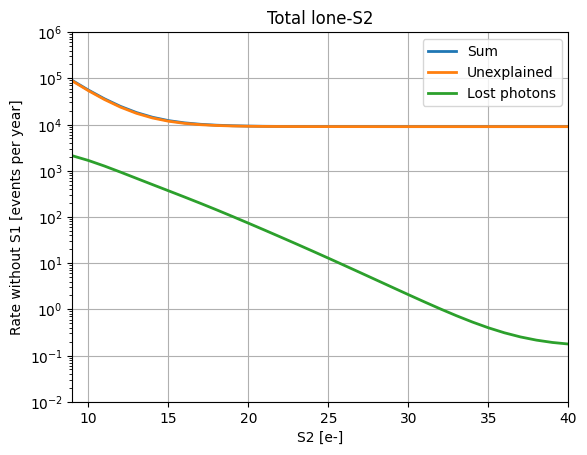

In [18]:
#Add lone-S2 unexplained
R_LS2_all = []
R_LS2_unexpl = []
for n in range(len(x_LS2)):
    Runexplained = instrumentalBackgrounds.RUnexplainedS2(n)
    #Runexplained=0
    R_LS2_unexpl.append(Runexplained)
    R_LS2_all.append( R_LS2[n] + Runexplained) 
fig_noS1tot, ax_noS1tot = plt.subplots()
ax_noS1tot.semilogy(x_LS2[0:100], R_LS2_all[0:100], linewidth=2.0, label="Sum")
ax_noS1tot.semilogy(x_LS2[0:100], R_LS2_unexpl[0:100], linewidth=2.0, label="Unexplained")
ax_noS1tot.semilogy(x_LS2[0:100], R_LS2[0:100], linewidth=2.0, label="Lost photons")
ax_noS1tot.grid()
ax_noS1tot.legend()
plt.xlim([9, 40])
plt.ylim([1e-2, 1e6])
ax_noS1tot.set_xlabel("S2 [e-]")
ax_noS1tot.set_ylabel("Rate without S1 [events per year]")
ax_noS1tot.set_title("Total lone-S2")


0: 1, 10660495310569.174
1: 2, 979745780012.9952
2: 3, 45021484832.96137
3: 4, 1379269705.798929


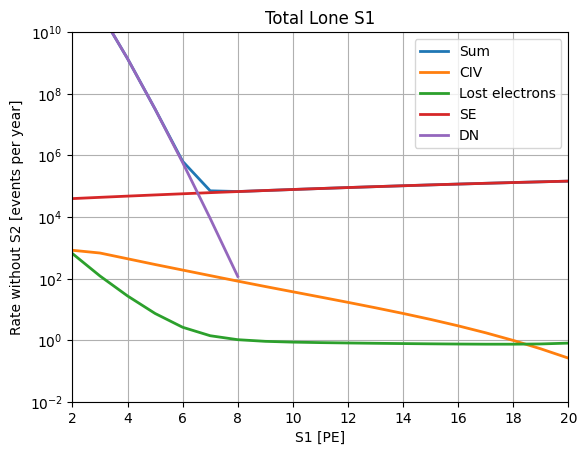

In [19]:
#Now add misclassified SE to S1 rate. 
# Single electrons are amplified given the SEgain.
# The SE gain spectrum is quite wide, so some fraction of them shows up at 
# much lower PE than they should and can be misclassified as an S1 with some probability.
R_LS1_all = []
R_LS1_SE = []

#x_DN = np.linspace(1, 8, 8)
#y_DNCoincidenceRate 

#x_LS1_PE = []
#R_LS1_FromCIV_PE = [] 
#R_LS1_Rad_PE = [] 


if (x_LS2[0] != 1):
    print ("Problem!")
    
SErate = R_LS2_all[0]*instrumentalBackgrounds.S1MisclassificationProb
for i in range(len(x_LS1_PE)):
    R_LS1_SE.append(0)
    R_LS1_all.append(0)
   # print(str(i) + ", " + str(x_LS1_PE[i]))
    R_LS1_SE[i] = SErate*instrumentalBackgrounds.SESpectrum(x_LS1_PE[i])
    R_LS1_all[i] = R_LS1_SE[i] + R_LS1_FromCIV_PE[i] + R_LS1_Rad_PE[i]
    
    if i < len(y_DNCoincidenceRate):
        R_LS1_all[i] = R_LS1_all[i] + y_DNCoincidenceRate[i]


fig_noS2total, ax_noS2total = plt.subplots()
ax_noS2total.semilogy(x_LS1_PE, R_LS1_all, linewidth=2.0, label="Sum")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_FromCIV_PE, linewidth=2.0, label="CIV")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_Rad_PE, linewidth=2.0, label="Lost electrons")
ax_noS2total.semilogy(x_LS1_PE, R_LS1_SE, linewidth=2.0, label="SE")
ax_noS2total.semilogy(x_DN, y_DNCoincidenceRate, linewidth=2.0, label="DN")
ax_noS2total.grid()
plt.xlim([2, 20])
plt.ylim([1e-2, 1e10])
ax_noS2total.legend(loc='upper right')
ax_noS2total.set_xlabel("S1 [PE]")
ax_noS2total.set_ylabel("Rate without S2 [events per year]")
ax_noS2total.set_title("Total Lone S1")   
for i in range(4):
    print (str(i) + ": " + str(x_LS1_PE[i]) + ", " + str(R_LS1_all[i]))

rate in red box is 36206.7298 events/year


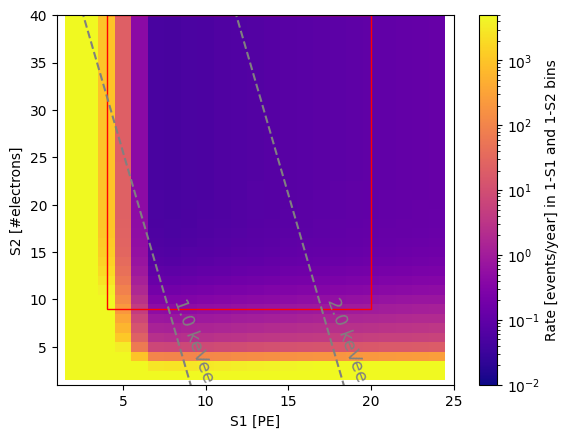

In [20]:
# Mixing them up
## 
## Lone-S1: x_LS1_PE, R_LS1_all
## Lone-S2: x_LS2, R_LS2_all
X_mix, Y_mix = np.meshgrid(x_LS1_PE, x_LS2)
Z_ACPDF = np.eye(len(x_LS2),len(x_LS1_PE))

for i in range(len(R_LS1_all)):
    for j in range(len(R_LS2_all)):
        if (i ==0 or j==0):Z_ACPDF[j,i] = 0.0
        else: Z_ACPDF[j,i] =  R_LS1_all[i]*R_LS2_all[j]*detector.MaxDriftTime*1./ACClasses.SecondsPerYear*1e-9
        #note inverted "i,j" due to weird axis definitions in np.meshgrid
        
        
def get_eq_energy(en, g1=detector.g1, g2=1, W=18e-3):
    cs1_max = en/W*g1
    cs1_ = np.linspace(0, 20, 501)
    cs2_ = g2*(en/W - cs1_/g1)
    return (cs1_, cs2_,cs1_max)
ens = [1., 2.] 
yrange=(1,300)
#plt.yscale("log")



fig_mix, ax_mix = plt.subplots()
levels = np.ndarray((5,), buffer=np.array([1e-10, 1e-8, 1e-6, 1e-4, 1e-2]))
plt.xlim([1, 25])
plt.ylim([1, 40])
im = ax_mix.pcolormesh(X_mix, Y_mix,  Z_ACPDF, norm=colors.LogNorm(vmin=1e-2, vmax=5e3), cmap='plasma')
ax_mix.set_ylabel("S2 [#electrons]")
ax_mix.set_xlabel("S1 [PE]")
for en in ens:
    l_ = get_eq_energy(en)
    ax_mix.plot(l_[0],l_[1], c="0.5", ls ="--")
    ax_mix.text(l_[2], yrange[0]*1.03, "{:0.1f} keVee".format(en),fontsize=13, rotation=290,
                va="bottom", ha="center", color="0.5")
#plt.xticks(np.arange(0, 20, 2))
#plt.yticks(np.arange(0, 40, 2))
ax_mix.set_title("")
fig_mix.colorbar(im, ax=ax_mix, label="Rate [events/year] in 1-S1 and 1-S2 bins")

#calculate rate in a box
xmin = 4
xmax = 20
ymin = 9
ymax = 40
rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth=1, edgecolor='r', facecolor='none')
ax_mix.add_patch(rect)
totalrate = 0.0
for i in range(len(X_mix[0])):
    for j in range(len(Y_mix[1])):
        if (X_mix[0][i] >= xmin and X_mix[0][i] < xmax):
            if (Y_mix[j,i] >= ymin and Y_mix[j,i] < ymax):
                #print("x:" + str (X_mix[0][i]) + ", y:" + str(Y_mix[j,i]) + " :" + str(Z_mix[j,i]))
                totalrate = totalrate + Z_ACPDF[j,i]

print("rate in red box is " + "{:.4f}".format(totalrate) + " events/year")
plt.savefig("AC_S1S2.pdf", format="pdf",bbox_inches="tight")
np.savetxt("test.txt",Z_ACPDF)